In [1]:
# Mounted google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!pip install face-recognition

In [2]:
# Imported libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import cv2
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import random
from os import listdir
from os.path import isfile, join

from math import floor
from scipy.ndimage.interpolation import zoom, rotate

import imageio
#import face_recognition

In [3]:
# Creating a Dictionary to define Image Dimensions
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [4]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [5]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
  # Created init method
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        # Defined a gradient Descent optimizer variable and set the LR in the constructor
        optimizer = Adam(lr = learning_rate)
        # Defined parameters to compile the model
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    # Create method called init_model
    def init_model(self): 
      #Create a variable X and assigned input layer to pass the image dimensions
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        # Convoulutional Layers
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        # Batch Normalization
        x1 = BatchNormalization()(x1)
        # Max Pooling 
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [6]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('/content/drive/MyDrive/Colab Notebooks/Meso4_DF') 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [8]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [9]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to /content/drive/MyDrive/Colab Notebooks/web-cam-images/Real/photo.jpg


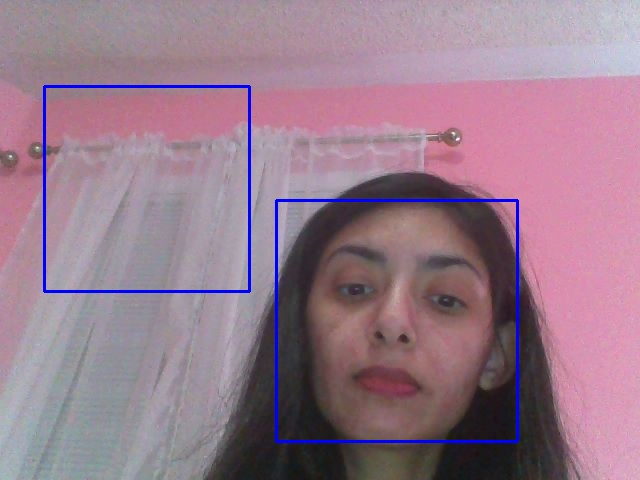

In [10]:
try:
  filename = take_photo('/content/drive/MyDrive/Colab Notebooks/web-cam-images/Real/photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [20]:
#image generator to predict images
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/web-cam-images/',
        target_size=(256, 256),
        batch_size= 1,
        class_mode='binary',
        subset='training')

X, y = generator.next()
print('Predicted :', meso.predict(X), '\nReal class :', y)

Found 2 images belonging to 3 classes.
Predicted : [[0.9645696]] 
Real class : [2.]


In [17]:
# Checking class assignment
generator.class_indices

{'.ipynb_checkpoints': 0, 'Deep Fake': 1, 'Real': 2}

In [18]:
!rm -rf `find -type d -name .ipynb_checkpoints`

Predicted likelihood: 0.9646
Actual label: 2

Correct prediction: False


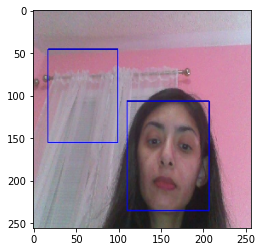

In [19]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));
#predictions closer to 0 are fake and predictions closer to 1 are real